# Model na danych tabelarycznych

In [1]:
import pandas as pd
import numpy as np
import pydicom
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from scipy.stats import skew

In [2]:
df = pd.read_csv('RSNA/df_processed.csv')

Pozbądżmy się zbędnych zmiennych.

In [3]:
df.drop(["Unnamed: 0", 'ID', 'x', 'y', 'width', 'height'], axis=1, inplace=True)

### Dodanie dodatkowych danych
Na samej płci i wieku model dużo się nie nauczy (model na samym dole), więc dodajmy kilka statystyk na podstawie wartości pikseli.

In [ ]:
img_list = df['Img'].to_list()
n = len(img_list)
mean_list = [None for _ in range(n)]
median_list = [None for _ in range(n)]
variance_list = [None for _ in range(n)]
skew_list = [None for _ in range(n)]
max_list = [None for _ in range(n)]

In [ ]:
for i, img in enumerate(img_list):
    print(f'{i+1}/{n}', end='\r')
    pa = pydicom.dcmread(img).pixel_array
    mean_list[i] = np.mean(pa)
    median_list[i] = np.median(pa)
    variance_list[i] = np.var(pa)
    skew_list[i] = skew(pa, axis=None)
    max_list[i] = np.max(pa)

In [ ]:
df = df.assign(mean = mean_list, median = median_list, variance = variance_list, skewness = skew_list, maximum = np.array(max_list, dtype='int16'))

In [ ]:
df.to_csv('RSNA/df2.csv')

In [4]:
df = pd.read_csv('RSNA/df2.csv')
df.drop(['Unnamed: 0', 'Img'], axis=1, inplace=True)

In [5]:
df.head()

,Sex,Age,View_position,Target,mean,median,variance,skewness,maximum
0,0,0.549451,0,0,120.191807,127.0,5457.311050,-0.152086,245
1,0,0.197802,1,0,114.285375,130.0,4309.093087,-0.513114,255
2,0,0.263736,1,1,109.134285,116.0,2963.487241,-0.604387,209
3,0,0.263736,1,1,109.134285,116.0,2963.487241,-0.604387,209
4,1,0.428571,1,1,129.509637,144.0,2685.265685,-1.068362,233


Należy pozbyć się view_position (AP czy PA), ponieważ jest on zbyt mocno skorelowany z chorobą - wynika to z faktu iż zdjęcia w jednej z pozycji są robione dla osób, które są w złym stanie zdrowotnym, co zwykle samo w sobie wiąże się z chorobą.

In [6]:
df.drop('View_position', axis=1, inplace=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Target', axis=1), df['Target'], random_state=42, test_size=0.3)

In [16]:
X_train.head()

,Sex,Age,mean,median,variance,skewness,maximum
17742,0,0.582418,163.996026,169.0,1344.804762,-1.003639,255
21392,1,0.153846,93.640652,81.0,4903.821528,0.324653,255
29095,0,0.637363,150.438485,170.0,3497.811194,-1.340493,255
9392,1,0.626374,113.222254,108.0,2490.286104,-0.048288,224
20302,1,0.384615,100.472043,94.0,4590.733614,0.179412,255


In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train.drop(['Sex', 'Age'], axis=1))
collist = ['mean', 'median', 'variance', 'skewness', 'maximum']
X_train[collist] = scaler.transform(X_train.drop(['Sex', 'Age'], axis=1))
X_test[collist] = scaler.transform(X_test.drop(['Sex', 'Age'], axis=1))

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef
def show_cm(model, X_test, y_test):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()
    
def scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('%18s %.3f' % ('Accurracy', model.score(X_test, y_test)))
    print('%18s %.3f' % ('F1 score', f1_score(y_test, y_pred, average='micro')))
    print('%18s %.3f' % ('MCC Score', matthews_corrcoef(y_test, y_pred)))
    show_cm(model, X_test, y_test)
    plt.show()

### Uczenie modelu

C:\Users\Patryk\pythonenv\396\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
             Train
        -----------------
         Accurracy 1.000
          F1 score 1.000
         MCC Score 0.999


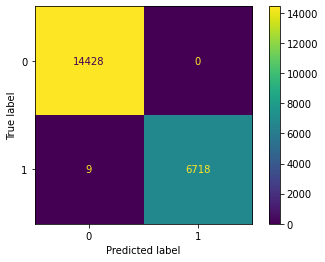

              Test
        -----------------
         Accurracy 0.812
          F1 score 0.812
         MCC Score 0.559


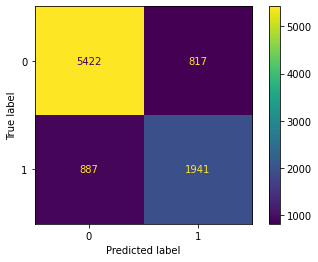

In [19]:
xgb = XGBClassifier(random_state=42, n_estimators=1200)
xgb.fit(X_train, y_train)
print('%18s' % ('Train'))
print('%25s' % ('-----------------'))
scores(xgb, X_train, y_train)
print('%18s' % ('Test'))
print('%25s' % ('-----------------'))
scores(xgb, X_test, y_test)

In [20]:
xgb.feature_importances_

array([0.11049204, 0.1324819 , 0.13689426, 0.18586618, 0.1564945 ,
       0.13935962, 0.13841149], dtype=float32)

Wszystkie zmienne są podobnie ważne dla modelu i jest on w stanie osiągnąć całkiem dobre wyniki.

In [21]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[['Sex', 'Age']], df['Target'], random_state=42, test_size=0.3)

C:\Users\Patryk\pythonenv\396\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
             Train
        -----------------
         Accurracy 0.685
          F1 score 0.685
         MCC Score 0.078


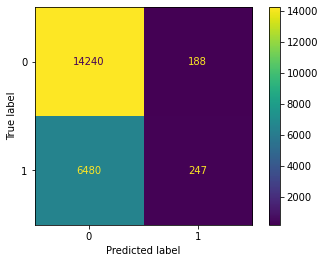

              Test
        -----------------
         Accurracy 0.689
          F1 score 0.689
         MCC Score 0.066


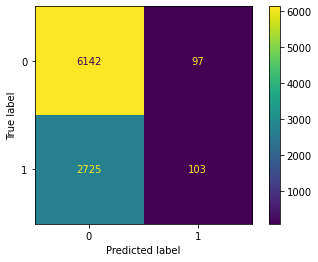

In [28]:
xgb2 = XGBClassifier(random_state=42, n_estimators=1000, reg_alpha=4)
xgb2.fit(X_train2, y_train2)
print('%18s' % ('Train'))
print('%25s' % ('-----------------'))
scores(xgb2, X_train2, y_train2)
print('%18s' % ('Test'))
print('%25s' % ('-----------------'))
scores(xgb2, X_test2, y_test2)

Bez dodatkowych statystyk model nie jest w stanie się nauczyć.